In [78]:
import os
import random
import time

import numpy as np

import matplotlib.pyplot as plt

In [79]:
class GA:
    def __init__(self):

        # 自由设定的变量
        self.population_size = 150
        self.max_iteration = 2000
        self.crossover_probability = 0.75
        self.mutate_probability = 0.2
        self.tournament_size = 8

        # 自适应改进变量
        self.enable_improve = 1
        self.pm_max = 0.4
        self.pm_min = 0.1
        self.pc_max = 0.9
        self.pc_min = 0.6

        # 根据输入文件变更的变量
        self.node_length = 0
        self.distance_metrix = None
        self.init_node_list = []

        # 辅助运算的变量
        self.__distance_metrix = None
        self.plt_distance = np.zeros(self.max_iteration)

        # 算法统计的变量
        self.best_path = None
        self.best_len = None
        self.all_time = None
        self.one_time_list = []

    def read_file(self, file_path):
        """读文件, 计算距离矩阵"""
        if not os.path.isfile(file_path):
            # 文件不存在
            return False

        with open(file_path, "r") as file:
            for line in file:
                if line is not None:
                    if line[0].isdigit():
                        # 数据行读入
                        line = line.strip()
                        line_elements = line.split()
                        # 转为浮点数便于计算
                        self.init_node_list.append((float(line_elements[1]), float(line_elements[2])))

        n = len(self.init_node_list)
        self.node_length = n

        self.__distance_metrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i+1, n):
                # 求出两点间的欧氏距离
                d = np.linalg.norm(np.array(self.init_node_list[i]) - np.array(self.init_node_list[j]))
                self.__distance_metrix[i, j] = self.__distance_metrix[j, i] = d

        self.distance_metrix = self.__distance_metrix

        return True

    def init_population(self, node_list=None, population_size=None):
        if node_list is None:
            node_list = self.init_node_list
        if population_size is None:
            population_size = self.population_size

        population = []

        for i in range(population_size):
            # 使用排列作为种群个体
            if self.enable_improve:
                start_node = random.randint(0, self.node_length-1)
                permutation=self.greedy(start_node)
            else:
                # 向种群中加入随机打乱的排列
                permutation = np.arange(len(node_list))
                np.random.shuffle(permutation)
            population.append(permutation)

        return population

    def fitness(self, single_path, node_list):
        """计算种群适应度"""

        distance = self.__distance_metrix[int(single_path[-1]), int(single_path[0])]
        for i in range(len(node_list) - 1):
            distance += self.__distance_metrix[single_path[i], single_path[i + 1]]

        return 1 / distance

    def select(self, population, node_list):
        """选择操作"""
        # 适应度列表
        fitness_list = np.array([self.fitness(i, node_list) for i in population])

        # 当前种群适应度排序，从大到小
        # np.argsort(-np.array([self.fitness(i, node_list) for i in population]))

        # 选用锦标赛算子
        # 选取优良个体
        select_list = []
        for i in range(self.population_size):
            # 锦标赛算法
            players = np.random.choice(np.arange(self.population_size), size=self.tournament_size, replace=False) # n个随机选手
            best_player = players[np.array([fitness_list[player] for player in players]).argmax()]
            select_list.append(population[best_player])
        return select_list

    def crossover(self, population):
        """染色体交叉"""
        crossover_list = []

        if self.enable_improve:
            fitness_list = np.array([self.fitness(i, self.init_node_list) for i in population])
            current_avg = np.mean(fitness_list)

        for i in range(0, self.population_size, 2):

            crossover_probability = self.crossover_probability
            if self.enable_improve:
                fi = (fitness_list[i] + fitness_list[i+1]) / 2 * current_avg
                crossover_probability = self.pc_min*fi + self.pc_max*(1-fi)
            if np.random.random_sample() <= crossover_probability:
                child1, child2 = self.crossover_ox_op(population[i], population[i+1])
                crossover_list.append(child1)
                crossover_list.append(child2)
            else:
                crossover_list.append(population[i])
                crossover_list.append(population[i+1])

        return crossover_list

    def crossover_ox_op(self, parent1, parent2):
        """顺序交叉算子"""
        # 初始化
        child1 = np.zeros(self.node_length)
        child2 = np.zeros(self.node_length)

        # 生成两个位点
        pos1, pos2 = np.random.choice(np.arange(self.node_length), size=2, replace=False)
        if pos1 > pos2:
            pos1, pos2 = pos2, pos1

        # 复制选取的段
        child1[pos1: pos2] = parent1[pos1: pos2]
        child2[pos1: pos2] = parent2[pos1: pos2]

        # 父母去掉已复制的段
        tmp1 = np.delete(parent1, np.where(np.isin(parent1, parent2[pos1: pos2])))
        tmp2 = np.delete(parent2, np.where(np.isin(parent2, parent1[pos1: pos2])))

        # 剩余部分按顺序交换
        child1[0: pos1] = tmp2[0: pos1]
        child2[0: pos1] = tmp1[0: pos1]
        child1[pos2:] = tmp2[pos1:]
        child2[pos2:] = tmp1[pos1:]

        return child1.astype(int), child2.astype(int)

    def mutate(self, population):
        """变异"""
        mutate_list = []

        if self.enable_improve:
            fitness_list = np.array([self.fitness(i, self.init_node_list) for i in population])
            current_avg = np.mean(fitness_list)

        for i in range(self.population_size):
            mutate_probability = self.mutate_probability
            if self.enable_improve:
                fi = fitness_list[i] / current_avg
                mutate_probability = self.pm_min*fi + self.pm_max*(1-fi)

            if np.random.random_sample() <= mutate_probability:
                mutate_list.append(self.mutate_swap_op(population[i]))
            else:
                mutate_list.append(population[i])

        return mutate_list

    def mutate_swap_op(self, individual):
        """反转变异算子"""
        # 生成两个位点
        pos1, pos2 = np.random.choice(np.arange(self.node_length), size=2, replace=False)
        if pos1 > pos2:
            pos1, pos2 = pos2, pos1
        # 反转
        individual[pos1:pos2] = individual[pos1:pos2][::-1]

        return individual

    def run(self):
        # 记录最优解
        best_individual = None
        best_fitness = 0
        best_iteration = -1

        all_time_start = time.time()
        last_time = time.time()

        # 产生初始种群
        population = self.init_population()
        # 开始迭代
        for iteration in range(self.max_iteration):

            # 选择
            select_population = self.select(population, self.init_node_list)
            # 交叉
            crossover_population = self.crossover(select_population)
            # 变异
            mutate_population = self.mutate(crossover_population)
            # 新一代种群
            population = mutate_population

            # 统计
            fitness_list = np.array([self.fitness(i, self.init_node_list) for i in population])
            current_best_index = fitness_list.argmax()

            current_best_individual = population[current_best_index]
            current_best_fitness = fitness_list[current_best_index]

            if current_best_fitness > best_fitness:
                best_individual = current_best_individual
                best_fitness = current_best_fitness
                best_iteration = iteration

            self.plt_distance[iteration] = 1 / current_best_fitness

            now_time = time.time()
            self.one_time_list.append(now_time - last_time)
            last_time = now_time

            if iteration % 10 == 0:
                print(f'当前第{iteration}轮，当前轮次最优秀个体{1 / current_best_fitness}，所有轮次最优秀个体{1/best_fitness}，出现在第{best_iteration}轮')

            # self.crossover_probability = self.crossover_probability + (0.9-self.crossover_probability)*(iteration/self.max_iteration)
            # self.mutate_probability = self.mutate_probability - (self.mutate_probability - 0.2)*(iteration/self.max_iteration)

        self.all_time = time.time() - all_time_start
        self.best_path = best_individual
        print(f'求得最优解： {1/best_fitness}')
        self.best_len = 1/best_fitness

    def show_plot(self):
        x = np.arange(self.max_iteration)
        plt.plot(x, self.plt_distance)
        plt.ylim(ymin=567)
        plt.show()

        self.show_path_plot(self.best_path)

    def show_timer(self):
        print(f'总用时：{self.all_time} s')
        print(f'单轮平均用时：{sum(self.one_time_list)/len(self.one_time_list)} s')

    def show_path_plot(self, path:list):
        x = [i[0] for i in self.init_node_list]
        y = [i[1] for i in self.init_node_list]

        for i in range(len(path) - 1):
            plt.plot([x[path[i]], x[path[i + 1]]], [y[path[i]], y[path[i + 1]]], color='orange', zorder=1)
        plt.plot([x[path[0]], x[path[-1]]], [y[path[0]], y[path[-1]]], color='orange', zorder=1)

        plt.scatter(x, y, zorder=2)
        plt.show()

    def greedy(self, start_node):
        unvisited_nodes = list(set(range(self.node_length)))
        unvisited_nodes.remove(start_node)
        current_node = start_node
        path = [current_node]
        while unvisited_nodes:
            next_node = min(unvisited_nodes, key=lambda x: self.distance_metrix[current_node][x])
            unvisited_nodes.remove(next_node)
            path.append(next_node)
            current_node = next_node
        return path


In [80]:
ga = GA()
ga.read_file('./Data/xqf131.tsp')

True

当前第0轮，当前轮次最优秀个体628.7206044979843，所有轮次最优秀个体628.7206044979843，出现在第0轮
当前第10轮，当前轮次最优秀个体627.9025882367963，所有轮次最优秀个体627.9025882367963，出现在第5轮
当前第20轮，当前轮次最优秀个体627.9025882367963，所有轮次最优秀个体627.9025882367963，出现在第5轮
当前第30轮，当前轮次最优秀个体622.0723549196671，所有轮次最优秀个体622.0723549196671，出现在第30轮
当前第40轮，当前轮次最优秀个体612.4542481809525，所有轮次最优秀个体612.4542481809525，出现在第34轮
当前第50轮，当前轮次最优秀个体606.8171587692973，所有轮次最优秀个体606.8171587692973，出现在第49轮
当前第60轮，当前轮次最优秀个体606.8171587692973，所有轮次最优秀个体606.8171587692973，出现在第49轮
当前第70轮，当前轮次最优秀个体606.8171587692973，所有轮次最优秀个体606.8171587692973，出现在第49轮
当前第80轮，当前轮次最优秀个体606.8171587692973，所有轮次最优秀个体606.8171587692973，出现在第49轮
当前第90轮，当前轮次最优秀个体606.8171587692973，所有轮次最优秀个体606.8171587692973，出现在第49轮
当前第100轮，当前轮次最优秀个体606.8171587692973，所有轮次最优秀个体606.8171587692973，出现在第49轮
当前第110轮，当前轮次最优秀个体606.8171587692973，所有轮次最优秀个体606.8171587692973，出现在第49轮
当前第120轮，当前轮次最优秀个体606.8171587692973，所有轮次最优秀个体606.8171587692973，出现在第49轮
当前第130轮，当前轮次最优秀个体606.8171587692973，所有轮次最优秀个体606.8171587692973，出现在第49轮
当前第140轮，当前轮次最优秀个体606.8171587692973

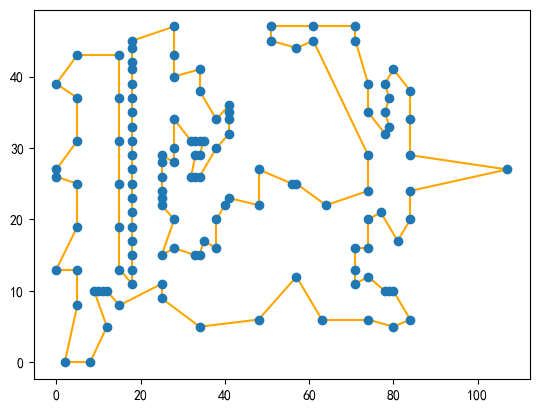

In [81]:
ga.run()
p1 = ga.plt_distance.copy()

ga.show_path_plot(ga.best_path)

In [58]:
print(ga.all_time)

70.35999631881714


In [59]:
ga.enable_improve = 0
ga.run()
p2 = ga.plt_distance.copy()

当前第0轮，当前轮次最优秀个体4091.870329453253，所有轮次最优秀个体4091.870329453253，出现在第0轮
当前第10轮，当前轮次最优秀个体3156.762914262127，所有轮次最优秀个体3156.762914262127，出现在第10轮
当前第20轮，当前轮次最优秀个体2738.2551482218782，所有轮次最优秀个体2738.2551482218782，出现在第20轮
当前第30轮，当前轮次最优秀个体2417.5810668363674，所有轮次最优秀个体2417.5810668363674，出现在第30轮
当前第40轮，当前轮次最优秀个体2256.9741699326596，所有轮次最优秀个体2256.9741699326596，出现在第40轮
当前第50轮，当前轮次最优秀个体2087.076572522706，所有轮次最优秀个体2087.076572522706，出现在第50轮
当前第60轮，当前轮次最优秀个体1891.2076603980447，所有轮次最优秀个体1891.2076603980447，出现在第60轮
当前第70轮，当前轮次最优秀个体1748.1111602412643，所有轮次最优秀个体1748.1111602412643，出现在第69轮
当前第80轮，当前轮次最优秀个体1655.3508003764175，所有轮次最优秀个体1655.3508003764175，出现在第80轮
当前第90轮，当前轮次最优秀个体1565.2660435200796，所有轮次最优秀个体1565.2660435200796，出现在第90轮
当前第100轮，当前轮次最优秀个体1478.7408787602242，所有轮次最优秀个体1478.7408787602242，出现在第100轮
当前第110轮，当前轮次最优秀个体1371.4618331882973，所有轮次最优秀个体1371.4618331882973，出现在第110轮
当前第120轮，当前轮次最优秀个体1315.83475939581，所有轮次最优秀个体1315.83475939581，出现在第120轮
当前第130轮，当前轮次最优秀个体1270.367606644843，所有轮次最优秀个体1270.367606644843，出现在第130轮
当前第140轮，当前轮次

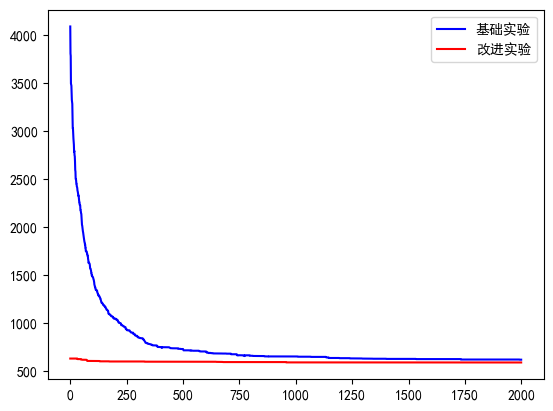

In [68]:
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
x = np.arange(ga.max_iteration)
plt.plot(x, p2, color='blue')
plt.plot(x, p1, color='red')
plt.legend(['基础实验', '改进实验'])
#plt.ylim(ymin=567)
plt.show()

In [69]:
ga.show_path_plot()

TypeError: list indices must be integers or slices, not numpy.float64

In [28]:
p2

array([3970.54741115, 3783.98644538, 3707.06412744, ...,  645.46154016,
        645.46154016,  645.46154016])

In [30]:
def greedy(distance_matrix, start_node):
        unvisited_nodes = set(range(len(distance_matrix)))
        unvisited_nodes.remove(start_node)
        current_node = start_node
        path = [current_node]
        while unvisited_nodes:
            next_node = min(unvisited_nodes, key=lambda x: distance_matrix[current_node][x])
            unvisited_nodes.remove(next_node)
            path.append(next_node)
            current_node = next_node
        return path